# WASP 39 b

## Learning Goals:

This notebook will present the data for WASP 39b as observed by TESS. Data presented here will complement those derived from the JWST early release science. 

The notebook will teach the user how to do the following:

1. Search TESS for data on the WASP-39 system using *Lightkurve*.
2. Download a light curve.
3. Find the transiting planet via a box least squares periodogram analysis.
4. Obtaining a light curve from the TPF and reducing the data.

To learn more about the TESS mission in general and the various data products please visit the [TESS Science Support Center](https://heasarc.gsfc.nasa.gov/docs/tess/).

## Introduction: 
The WASP 39 system is located approximately 698 light-years from the Earth, with late G-type host star which is roughly 90% the mass and radius of our own Sun.

The system is host to WASP-39 b, a highly inflated transiting Saturn mass planet which is about 30% percent the mass of Jupiter, and 30% larger. The orbital period of the planet around the host is approximately 4 days. You can learn more about this system and its parameters via the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/WASP%2039).

This planet is an interesting as it seems to have three times the amount of water vapor in its atmosphere as detected on Saturn. This object was therefore selected for follow up by JWST.


## Imports

This tutorial requires the [*Lightkurve package*](https://docs.lightkurve.org/index.html), which uses [Matplotlib](https://matplotlib.org/) for plotting. We will also use [Numpy](https://numpy.org/).

In [1]:
%matplotlib inline 
import lightkurve as lk 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## First time users: 

If you are not that experienced with Python, or cannot download Lightkurve, you can run this notebook as a [Google Colab notebook](https://colab.research.google.com/?utm_source=scs-index). Colaboratory allows users to write and execute Python in your browser with zero configuration required.

All you need is a Google account and to copy and paste in the following command at the top of your colab notebook:

`!pip install lightkurve --quiet`

This downloads the Lightkurve package.

## 1. Search TESS for data on the WASP-39 system using *Lightkurve*.

Lightkurve offers a user-friendly way to analyze time series data obtained by the TESS mission. You can search for the various WASP-39 data products using the following functions:

- To the system in a full frame image: [`search_tesscut()`](https://docs.lightkurve.org/reference/api/lightkurve.search_tesscut.html?highlight=search_tesscut)
- To look for target pixel files: [`search_targetpixelfile()`](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile)
- To obtain light curve files for WASP-39: [`search_lightcurve()`](https://docs.lightkurve.org/reference/api/lightkurve.search_lightcurve.html?highlight=search_lightcurve)



### 1.1 Accessing the data products
Let’s go through each one of the above functions and see what data is available.

In [2]:
search_ffi = lk.search_tesscut('WASP39')
search_tpf = lk.search_targetpixelfile('WASP39')
search_lcf = lk.search_lightcurve('WASP39')

In [3]:
search_ffi

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,TESScut,475,WASP39,0.0


The above table provides several important pieces of information: 

- The sector in which the object was observed. 
- The year in which the object was observed. 
- The author of the data. This can have multiple options and each is a hyperlink that when clicked will provide you with more information. 
- The cadence of the observation. 
- The name of the target. 
- The distance of the observation from your target of interest. This is useful if you conduct a cone search around your objects co-ordinates.

The table above indicates that our object was observed in sectors 51 only.

Let’s see if any other data exists, i.e., was it observed as a target of interest and does it have a Target Pixel File.

In [4]:
search_tpf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,120,181949561,0.0


Our object was observed as a target of interest in Sector 51. Given that there is SPOC data this means that there should be light curve files for our object already in the archive. Let’s check those out.

In [5]:
search_lcf

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 51,2022,SPOC,120,181949561,0.0


Wonderful! A light curve for our object of interest has already been created. 

## 2. Download a light curve:
Now on to getting the light curve for our object of interest. Since there is only one light curve this is pretty straight forward.

In [6]:
lc = search_lcf[0].download(quality_bitmask='hard')

We can easliy plot these data using the following code

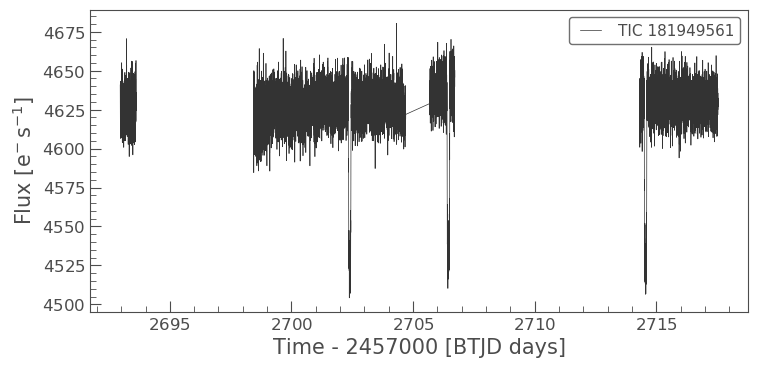

In [7]:
lc.plot()

We can clearly see the transit of our planet WASP-39 b around BTJD 2703, 2706 and 2714. 

Note that there are also several gaps in our light curve above. These are caused by standard data downloads (between 2704.69374 and 2705.67846) and an unusual increase in the background/scattered light (please see [TESS DRN 74](https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_sector_51_drn74_v01.pdf) caused by the Earth and Moon. As such we have a higher number of data gaps than normal. 

When we downloaded the system data previously, we specified that only good quality data be obtained. This was done via the specification of a  [`quality_bitmask`](https://docs.lightkurve.org/reference/api/lightkurve.TessTargetPixelFile.html?highlight=quality_bitmask) parameter. 

We'll set the bitmask to remove some cadences, but be less aggressive than the default mask. To learn more about the [`TESSQualityFlags`](https://docs.lightkurve.org/reference/api/lightkurve.TessQualityFlags.html?highlight=tessqualityflags#lightkurve.TessQualityFlags) and bitmasks please see the [STScI documentation](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview).

In [8]:
bitmask = (lk.utils.TessQualityFlags.SafeMode |
           lk.utils.TessQualityFlags.CoarsePoint |
           lk.utils.TessQualityFlags.ManualExclude )
print(bitmask)

134


This mask value removes the cadences that we are most confident will always have bad data; Safe Modes, poor pointing, and "manual" excludes where the TESS pipeline team has flagged a bad cadence. 

We'll set the light curve to a variable `lc0` as this is our first look at the light curve. Later in the tutorial, we will make an improved light curve. 

In [9]:
lc0 = search_lcf[0].download(quality_bitmask=bitmask)

Note that in this dataset, a solar system object moved close to our aperture during the observation, at BJD 2459714.05061599. Below we make a mask to clip the data approximately one hour around this event out. 

In [10]:
# Make a mask to remove the ~1 hour of data around where there was a solar system object close to the aperture.
lc0 = lc0[np.abs(lc0.time.jd - 2459714.05061599) > 0.025]

We will now plot this light curve looking at SAP flux and PDCSAP flux, which are described below:

- **Simple Aperture Photometry (SAP)**: The SAP light curve is calculated by summing together the brightness of pixels that fall within an aperture set by the TESS mission. This is often referred to as the optimal aperture, but in spite of its name, it can sometimes be improved upon! Because the SAP light curve is a sum of the brightness in chosen pixels, it is still subject to systematic artifacts of the mission.
- **Pre-search Data Conditioning SAP flux (PDCSAP) flux**: SAP flux from which long-term trends have been removed using so-called Co-trending Basis Vectors (CBVs). PDCSAP flux is usually cleaner data than the SAP flux and will have fewer systematic trends.

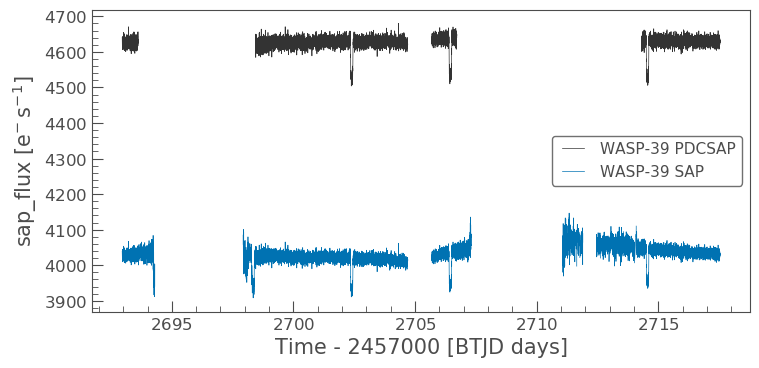

In [11]:
ax = lc0.plot(column="pdcsap_flux", label="WASP-39 PDCSAP")
lc0.plot(ax=ax, column="sap_flux", label="WASP-39 SAP")

We can see that the SAP flux contains more information than the PDCSAP, which has been refined to remove noise, scattered light, data with a larger than normal background, and instrumental effects. 

While the PDCSAP flux may be the best to derive the transit, the SAP data is still very useful and can be reduced further to provide a more complete light curve of the system. 

For now let us use the PDCSAP light curve to obtain the period of the system.

## 3. Find the transiting planet via a box least squares periodogram analysis.

You can use the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) to obtain the parameters for [WASP-39b](https://exoplanetarchive.ipac.caltech.edu/overview/WASP-39). You'll see it has a period of ~4.055 days. We can also use the TESS data to find a period and transit time. 

The most common method used to identify transiting exoplanets is the Box Least Squares (BLS) periodogram analysis. BLS works by modeling a transit using an upside-down top hat with four parameters: period, duration, depth, and reference time. (Please see the [Identifying transiting exoplanet signals in a light curve tutorial](https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-identifying-transiting-planet-signals.html) for more information on BLS and finding exoplanets with *Lightkurve*)

To analyze the light curve via the BLS method you must pass the data to the [`to_periodogram`](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html?highlight=to_periodogram) function and specify `bls` as the method. 

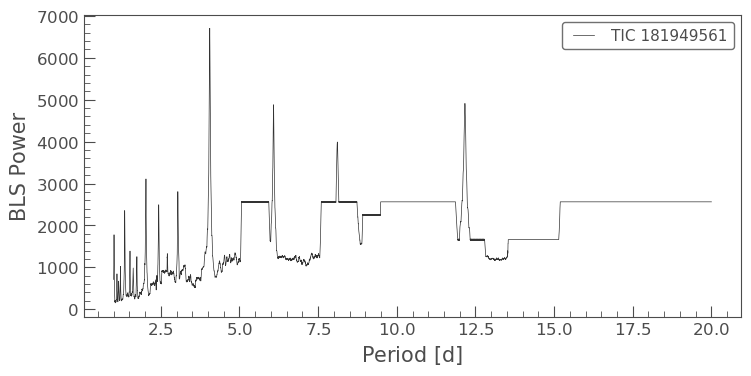

In [12]:
period = np.linspace(1, 20, 10000)
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

The above plot indicates the power, or the likelihood of the BLS fit, for each of the periods in lightcurve data. 
There are several spikes in the plot at specific periods, but the highest power spike shows the most likely period, the remaining lower power spikes are fractional harmonics of the period.

We can refine the BLS by using a lower frequency spacing, and using the `minimum_period` and `maximum_period` arguments search close to our known period.

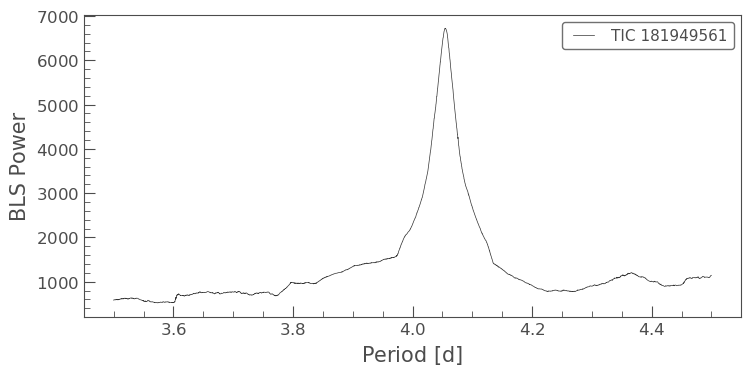

In [13]:
bls = lc.to_periodogram(method='bls',
                        minimum_period=3.5,
                        maximum_period=4.5,
                        frequency_factor=1,
                        duration=np.linspace(0.01, 0.3, 50));
bls.plot();

We can pull out the most likely BLS parameters by taking their values at maximum power as shown below.

In [14]:
WASP39_b_period = bls.period_at_max_power
WASP39_b_t0 = bls.transit_time_at_max_power
WASP39_b_dur = bls.duration_at_max_power

WASP39_b_period

<Quantity 4.05508588 d>

In [15]:
print(WASP39_b_period, WASP39_b_t0, WASP39_b_dur)

4.055085876297015 d 2694.2836837111436 0.099 d


We have now derived the period of the planet WASP39-b as ~4 days, which is consistent with that published.

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values and plot it.

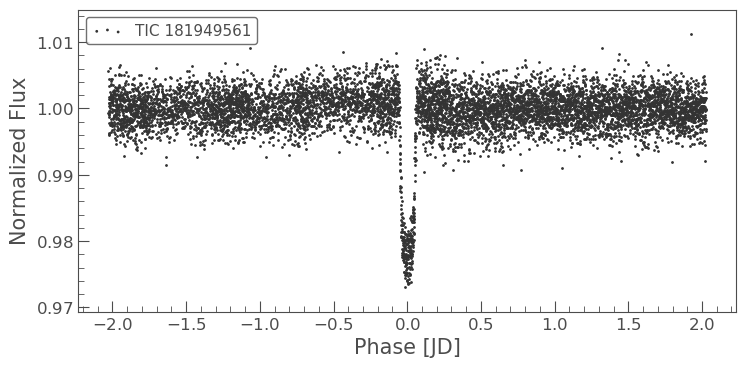

In [16]:
lc0.fold(period=WASP39_b_period, epoch_time=WASP39_b_t0).normalize().scatter()

Wonderful we have now plotted our transit!

## 4. Obtaining a light curve from the TPF and reducing the data

As we saw in the SAP light curve, there is some data which was removed by the PDCSAP pipeline due to the poor quality of the data. 

Can we obtain the light curve of our object from the TPF and reduced the data ourselves, improving some of these previously discarded data points? The answer is yes!

A copy of a more refined light curve can be found [here](https://github.com/rebekah9969/JWST-Sprint/blob/main/WASP-39b_TESS_Sector51_CorrectedLC.fits).

If you would like to learn how this light curve file was created, please continue with the tutorial. 

### 4.1 Creating a bitmask

First, we must download our objects target pixel file (TPF) and remove data that we think would reduce the quality of our light curve. We can do this by specifing a bitmask mask. To learn more about the [`TESSQualityFlags`](https://docs.lightkurve.org/reference/api/lightkurve.TessQualityFlags.html?highlight=tessqualityflags#lightkurve.TessQualityFlags) and bitmasks please see the [STScI documentation](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). We define our bitmask below. This time, we'll include a few more flags to make a slightly more aggressive mask.

In [17]:
bitmask = (lk.utils.TessQualityFlags.SafeMode |
           lk.utils.TessQualityFlags.CoarsePoint |
           lk.utils.TessQualityFlags.ManualExclude  |
           lk.utils.TessQualityFlags.Argabrightening | 
           lk.utils.TessQualityFlags.CollateralCosmic)

### 4.2 Downloading the TPF and applying our bitmask

In [18]:
tpf = search_tpf[0].download(quality_bitmask=bitmask)

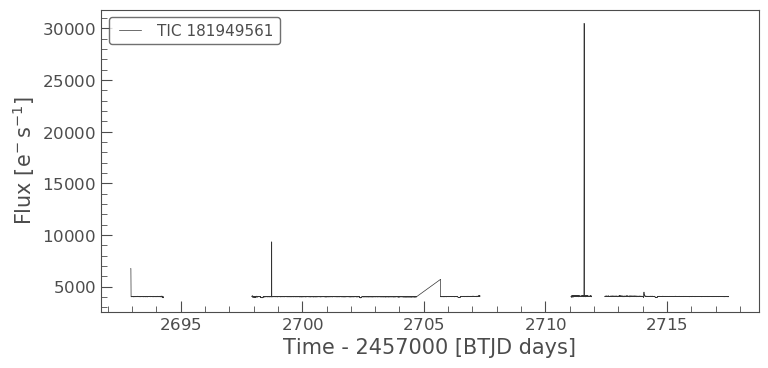

In [19]:
tpf.to_lightcurve().plot()

We need to remove the known solar system object from this data, as we did above. Once again we remove approximately one hour of data around where the solar system object was close to the aperture for our object of interest.

In [20]:
# Make a mask to remove the ~1 hour of data around where there was a solar system object close to the aperture.
tpf = tpf[np.abs(tpf.time.jd - 2459714.05061599) > 0.025]

We can now plot this and see what our object looks like.

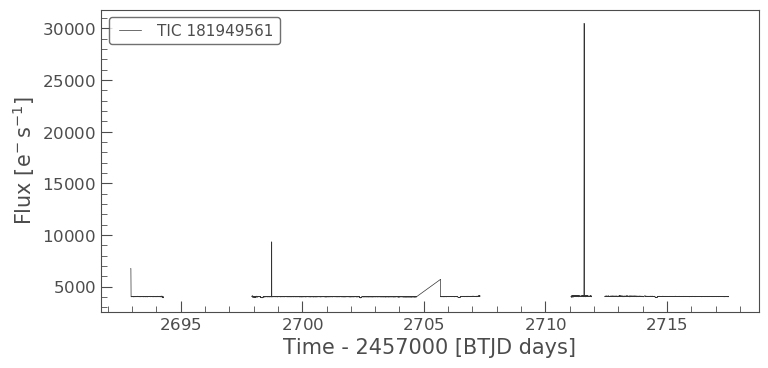

In [21]:
tpf.to_lightcurve().plot()

We can also over plot the aperture used by the SPOC to create the previously examined light curves. We do this using the `aperture_mask` parameter and the [`.pipeline_mask`](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.pipeline_mask.html?highlight=pipeline_mask#lightkurve.KeplerTargetPixelFile.pipeline_mask) function.

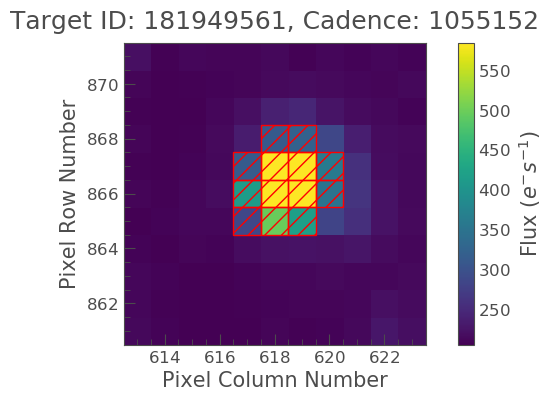

In [23]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

The TPF we are viewing is an official SPOC TPF, this means that the background estimates should be close to zero because these products have already been background-subtracted by the pipeline (i.e., the values in the FLUX_BKG column of the TPF have been subtracted from the values in FLUX). Background subtraction is often imperfect however, especially in this instance and as such you may want to view what the flux looks like and then re-estimate it.

## 4.2 Understanding the background flux

We can visualize the current background flux using the [`estimate_background`](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.estimate_background.html?highlight=estimate_background) function, and specifying the "background" aperture, as shown below. First we make a larger pixel aperture than the pipeline mask, to make sure we don't include any of our target flux. We specify this mask using a boolean array which we make bigger than our target mask by one pixel.

In [25]:
# This function makes a boolean mask larger by one pixel. 
enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x
bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)

We then apply this aperture mask using the `estimate_background` function.

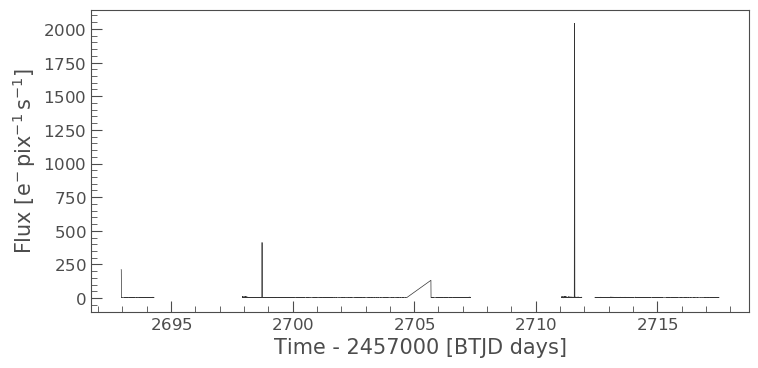

In [26]:
tpf.estimate_background(aperture_mask=~bigger_pipeline_mask).plot()

There are several peaks in this light curve which illustrate the background issues we see in the data.

We now want to re-estimate the background model based only on pixels close to the target. This lets us make sure we remove any high spatial or temporal frequency noise from close to the target. We can do this via the following method.

1. Add the pipeline background flux back into the data.

In [27]:
tpf += np.nan_to_num(tpf.flux_bkg)

2. Identify pixels not close to the source in order to create a new background aperture from which a background model can be derived.

In [28]:
# This function makes a boolean mask larger by one pixel. 
enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x
bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)

Lets compare our new background estimate to that from earlier 

3. Remove the median of this background model over time from the TPF flux.

In [29]:
tpf -= np.nanmedian(tpf.flux[:, ~bigger_pipeline_mask], axis=1)[:, None, None]

Great we now have a new TPF file which has a better background removal!

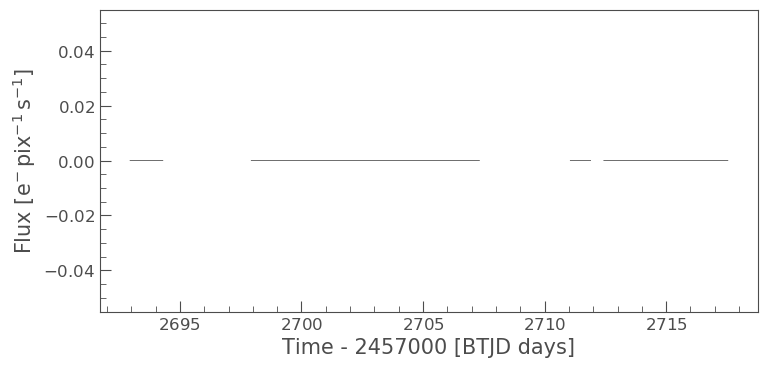

In [30]:
tpf.estimate_background(aperture_mask=~bigger_pipeline_mask).plot()

Next, we want to pull out the light curve for our object from this new and improved TPF. We do this using the [`to_lightcurve`](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.to_lightcurve.html?highlight=to_lightcurve#lightkurve.KeplerTargetPixelFile.to_lightcurve) function.

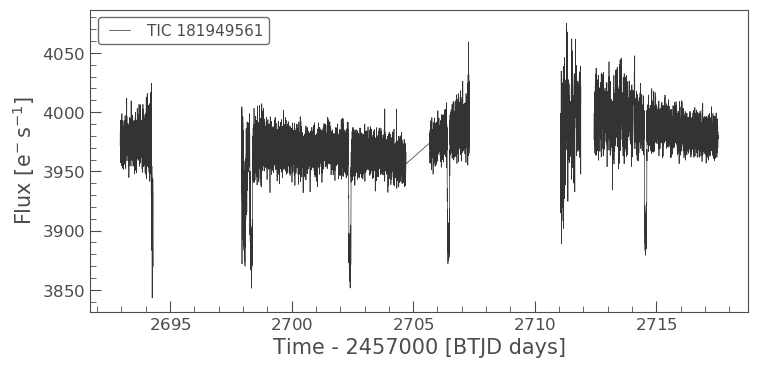

In [31]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

## 4.3 Refining our transit parameters

This light curve is still a little noisy and has some trends we don't believe, we will remove these later in the tutorial using our knowledge of the systematics. 

First, however we can improve our period, transit time and duration estimates using a the BLS method from before but refining our parameter inputs using those obtained from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/overview/WASP%2039).

```period : 4.0552941```

We can then apply the BLS via the method and fold the light curve to show the transit as demonstrated earlier in part 3 of this tutorial.

In [32]:
bls_refined = lc.normalize().to_periodogram('bls',
                                                minimum_period=4.0552941*0.99, 
                                                maximum_period=4.0552941*1.01, 
                                             duration=np.linspace(0.01, 0.1, 50), frequency_factor=1)
period, t0, dur = bls_refined.period_at_max_power.value, bls_refined.transit_time_at_max_power.value, bls_refined.duration_at_max_power.value,

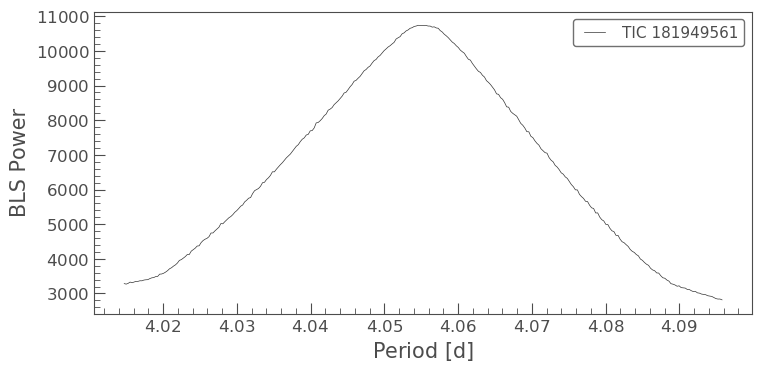

In [33]:
bls_refined.plot()

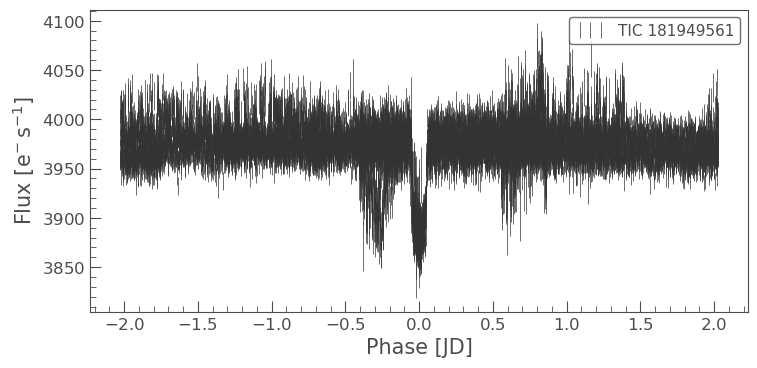

In [34]:
lc.fold(period, t0).errorbar()

## 4.4 Removing noise from our TPF light curve

As we can see there is still quite a bit of noise remining in the light curve and further reduction is required. 

For this tutorial we will correct our light curve using the following: 

1. The top three long time scale Cotrending Basis Vectors (CBVs) from the TESS mission
2. The top three Principal Components (PCs) of the pixels close to the source
3. A basis spline model to capture any variability in the light curve due to the star.
4. A simple box transit model, to ensure systematics do not fit out the transit.
5. A model for the jitter in TESS.

You can learn about the details of CBV application and linear regression via the applicaton of design matrices via the following *Lightkurve* tutorials: 

- [Removing noise from Kepler, K2, and TESS light curves using Cotrending Basis Vectors (CBVCorrector)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html)
- [Removing scattered light from TESS light curves using linear regression (RegressionCorrector)](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-removing-scattered-light-using-regressioncorrector.html)

First, we must obtain our CBVs from the mission.

In [35]:
from lightkurve.correctors import CBVCorrector
cbvc = CBVCorrector(lc)

These CBVs are associated with the CCD this target is on and for Sector 51. We can examine this object as follows:

In [36]:
cbvc.cbvs

[TESS CBVs, Sector.Camera.CCD : 51.1.3, CBVType : SingleScale, nCBVS : 16,
 TESS CBVs, Sector.Camera.CCD : 51.1.3, CBVType.Band: MultiScale.1, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 51.1.3, CBVType.Band: MultiScale.2, nCBVs : 8,
 TESS CBVs, Sector.Camera.CCD : 51.1.3, CBVType.Band: MultiScale.3, nCBVs : 1,
 TESS CBVs, Sector.Camera.CCD : 51.1.3, CBVType : Spike, nCBVS : 8]

We see that there are a total of 5 sets of CBVs, all associated with TESS Sector 51, Camera 1 and CCD 3. The number of CBVs per type is also given. We want only the top thre as the first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. We can specify our choices and apply these via the following code. 

In [37]:
ncbvs = 3
multiscale3 = cbvc.cbvs[2].interpolate(lc).to_pandas()
cbvs = np.asarray(multiscale3[multiscale3.columns[2:2+ncbvs]])

Extrapolation of CBVs appears to be necessary. Extrapolated values will be filled with zeros. Recommend setting extrapolate=True
Some interpolated (or extrapolated) CBV values have been set to zero


Below we plot the CBVs

Text(0.5, 0, 'Time [BTJD]')

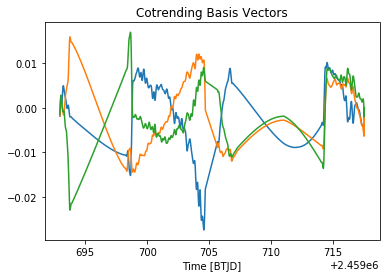

In [38]:
plt.plot(lc.time.jd, cbvs);
plt.title("Cotrending Basis Vectors")
plt.xlabel("Time [BTJD]")

Next, we want to create our design matrix. Lightkurve provides a convenient [`DesignMatrix`](https://docs.lightkurve.org/reference/api/lightkurve.correctors.DesignMatrix.html?highlight=designmatrix) class which is designed to help you work with detrending vectors.

We want to look at cadences in our data where there is non NaN flux inside our aperture, and we want to specify the aperture from which we derive our trends. This aperture should be outside of our object aperture. We then want to specify the number of principal components in this matrix which we can do via the specification of `pca()`. 

The following code implements this process, starting with the PCA of the background pixels.

In [39]:
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)
dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_pipeline_mask]), name='bkg').pca(3)

Next, we want to create a matrix which contains our CBVs.

Note below, we create the CBV design matrix and then split it at any points in the light curve that have a siginificant data gap. We restrict this design matrix with some narrow priors to ensure that we don't over fit.

In [40]:
dm2 = lk.DesignMatrix(cbvs[k], name='cbvs', prior_mu=[0, 0, 0], prior_sigma=[0.01, 0.01, 0.01]).split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

We then create a design matrix with a spline that has 120 knots. This creates a smooth, flexible model to remove variability on approximately day long time scales.

In [41]:
dm3 = lk.designmatrix.create_spline_matrix(tpf.time.jd[k], n_knots=120)

We additionally can make a design matrix that includes a simple box model of our transit. This allows us to fit flexibly for the transit shape without having other noise components over fit. Here we have included the same model, shifted in phase to allow for any signals of secondary eclipses.

In [42]:
dm4 = lk.DesignMatrix(np.vstack([bls_refined.get_transit_mask(period, dur, t0).astype(float),
                                 bls_refined.get_transit_mask(period, dur, t0 + period/2).astype(float)]).T, name='transit')

Finally, we add in a design matrix that contains the `POSCORR` attribute from the TPF. This captures the motion of the target due to TESS jitter, and is built by the TESS pipeline.

In [43]:
dm5 = lk.DesignMatrix(np.nan_to_num(np.vstack([tpf.pos_corr1, tpf.pos_corr2, tpf.pos_corr1*tpf.pos_corr2]).T)[k], name='centroids', prior_mu=[0, 0, 0], prior_sigma=[0.01, 0.01, 0.01]).split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

We then combine these to form our final matrix to be applied.

In [44]:
dm = lk.DesignMatrixCollection([dm1, dm2, dm3, dm4, dm5])

Finally, let us correct our light curve using our design matrix.

In [45]:
r = lk.RegressionCorrector(lc[k].normalize())
clc = r.correct(dm)

# The RegressionCorrector has fit and removed out simple box model from `dm4`
# We add the best fit box transit back into the light curve here
clc += r.diagnostic_lightcurves['transit']

We can now assess the quality of our fit using the `diagnose` function

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0e9ed6090>,
      dtype=object)

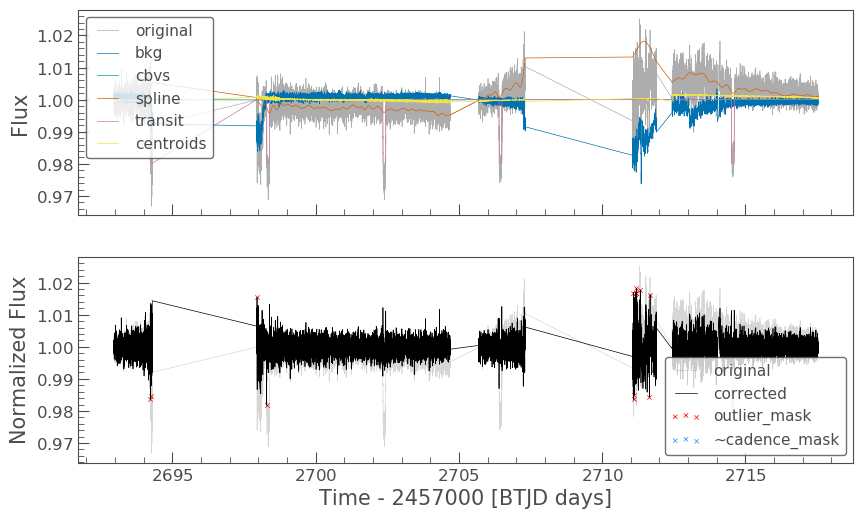

In [46]:
r.diagnose()

In these plots we can see each correction applied and the overall alteration on the initial light curve. We also note the outliers marked in red on the bottom plot, and the masked transits in blue. We can see that all the different components are fitting a different unique of the light curve, which is what we are trying to achieve.

Let us now compare to our earlier uncorrected light curve. 

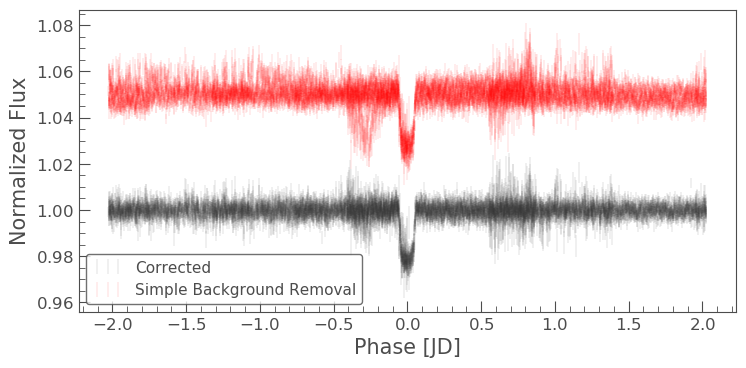

In [47]:
ax = clc.fold(period, t0).errorbar(ls='', label='Corrected', lw=0.1)
(lc.normalize().fold(period, t0) + 0.05).errorbar(ax=ax, c='r', ls='', label='Simple Background Removal', lw=0.1)

Here we have added an offset to make the distinction between the two light curves clear.

(-0.3, 0.3)

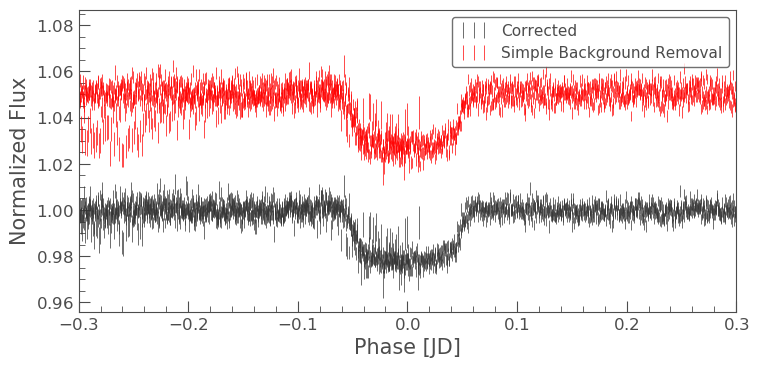

In [48]:
ax = clc.fold(period, t0).errorbar(ls='', label='Corrected', lw=0.5)
(lc.normalize().fold(period, t0) + 0.05).errorbar(ax=ax, c='r', ls='', label='Simple Background Removal', lw=0.5)
plt.xlim(-0.3, 0.3)

Our final light curve has an improvement in the noise properties and long term trends after our correction. We can check this by plotting a histogram of the out of transit flux. We see below, the corrected flux has a narrower histogram, showing it has a tigheter distribution.

Text(0, 0.5, 'Density')

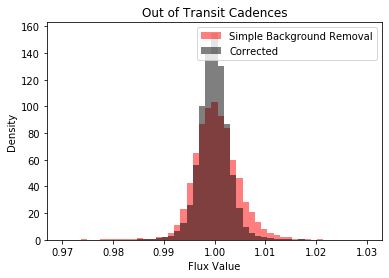

In [49]:
transit_mask = bls_refined.get_transit_mask(period, dur * 1.5, t0)
plt.hist(lc.normalize()[k][~transit_mask].flux.value, np.linspace(0.97, 1.03, 50), color='r', alpha=0.5, label='Simple Background Removal', density=True)
plt.hist(clc[~transit_mask].flux.value, np.linspace(0.97, 1.03, 50), color='k', alpha=0.5, label='Corrected', density=True);
plt.title("Out of Transit Cadences")
plt.legend()
plt.xlabel("Flux Value")
plt.ylabel("Density")

Below we plot the individual transits from the light curve.

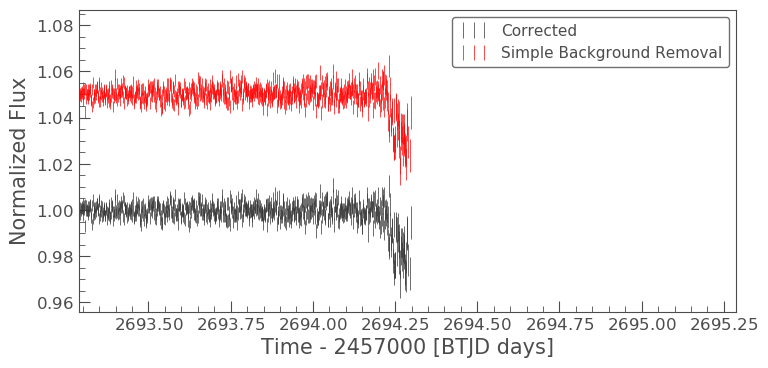

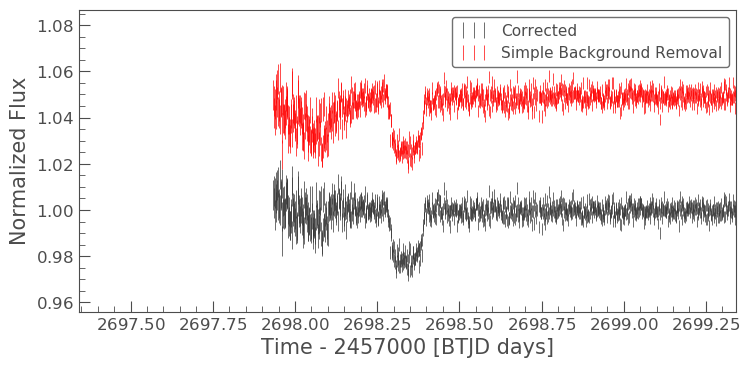

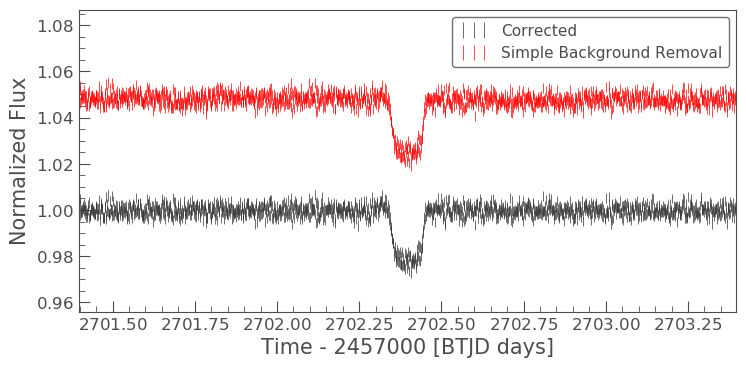

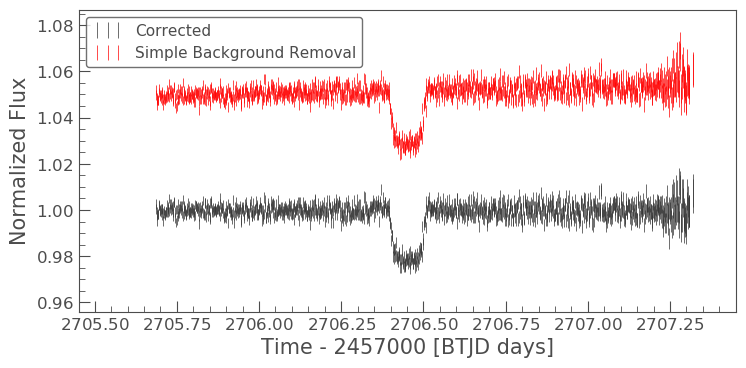

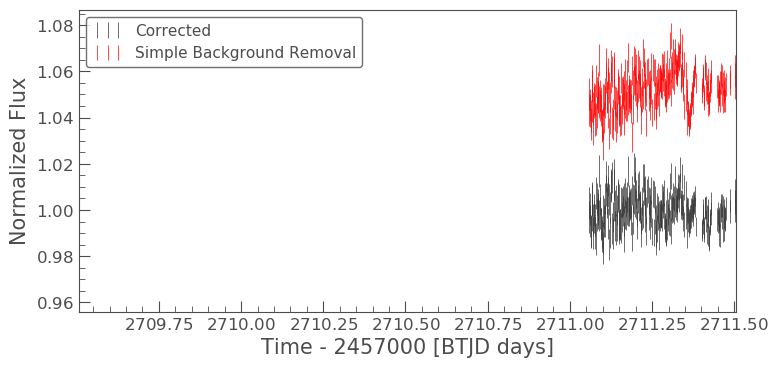

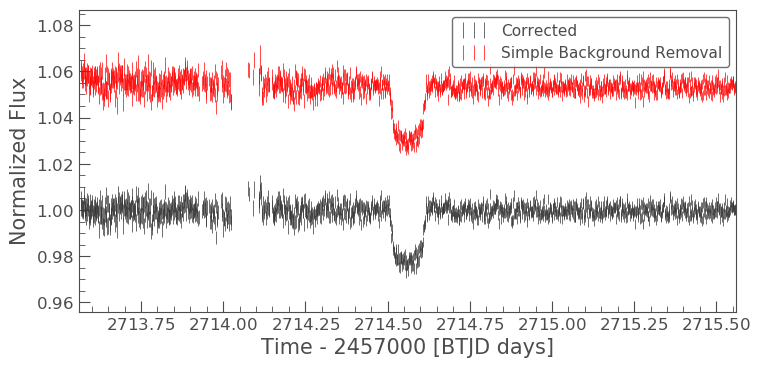

In [50]:
transit_times = bls_refined.compute_stats(period, dur, t0)['transit_times']
for t in transit_times:
    ax = clc.errorbar(ls='', label='Corrected', lw=0.5)
    (lc.normalize() + 0.05).errorbar(ax=ax, c='r', ls='', label='Simple Background Removal', lw=0.5)
    plt.xlim(t.jd - 1 - 2457000, t.jd + 1 - 2457000)

We can now write out our final corrected light curve to a fits file.

In [51]:
clc.to_fits('WASP-39b_TESS_Sector51_CorrectedLC.fits', overwrite=True)